In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


In [2]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [3]:
x=1
y=3
x+y



4

In [4]:
# Load the HDF5 file
with h5py.File('DF_event_based-Copy1.h5', 'r') as hf:
    # Access the dataset by name and load it into a pandas dataframe
    df_total = pd.DataFrame(hf['dataset_name'][:])

with h5py.File('4_event_types_weights-Copy1.h5', 'r') as f:
    df_weights = f['array'][:]

In [5]:
# df's now have no titles, but doesnt matter for the model obvs.

# df column headers
column_names = ['dataset', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'ncleanedBJet',
       'ncleanedJet']


# use rename() to rename columns
df_total = df_total.rename(columns=dict(zip(df_total.columns, column_names)))

df_total

,dataset,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet
0,0.0,363.519776,409.411560,0.248169,253.625,230.740250,0.084954,0.294236,0.023754,0.0,2.0
1,0.0,129.015341,466.076111,1.818359,308.250,339.473511,1.546004,1.134799,0.854612,1.0,5.0
2,0.0,274.769255,361.570465,0.668945,278.250,264.123840,0.621207,0.710851,0.103618,1.0,2.0
3,0.0,82.854809,359.750671,0.380127,218.750,227.014053,0.612625,0.612626,0.227535,0.0,3.0
4,0.0,82.354687,314.990326,1.387695,234.625,254.779617,1.441802,1.138652,0.881872,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
881091,1.0,353.306746,550.468018,0.340576,263.250,239.813583,0.811556,0.646585,0.334731,0.0,4.0
881092,1.0,206.457350,625.009277,0.468018,313.500,335.351562,0.991184,0.991184,0.872011,0.0,7.0
881093,1.0,511.200694,1002.960999,0.073547,245.875,249.904602,0.145308,0.145308,0.145308,1.0,8.0
881094,1.0,271.667337,525.788696,1.009766,210.500,226.901993,1.204100,0.954423,0.820283,1.0,5.0


In [6]:
X = df_total.copy()   
X.drop(['dataset'], axis = 1, inplace = True)   #Need to remove dataset (prediction) column
X = X.values


y = df_total['dataset']
y=y.values

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=48)  
# just put in different random states, need to use same states in RNN and MLP w/ RNN, so will use same across all here

input_shape = [X_train.shape[1]]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')
#print(len(x))
#print(len(y))
print(input_shape)

There are [10] variables in this model
The dataset has 881096 processes
[10]


In [7]:
#Define the Model

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape), 
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units=1, activation='sigmoid'),
])


from tensorflow.keras.optimizers import Adam

lr = 0.00005 # specify learning rate
optimizer = Adam(learning_rate=lr)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy')



model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [8]:
# Train the model, on the full data set

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    
class_weight = {0: class_weights[0], 
               1: class_weights[1]}        

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=15,
    callbacks=[early_stopping],
    #verbose = 0   #Hide output of epochs
    class_weight = class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

#takes like 10 mins to run rn, only 3 layers

Train on 704876 samples, validate on 176220 samples
Epoch 1/15
140800/704876 [====>.........................] - ETA: 17s - loss: 0.6728 - binary_accuracy: 0.6226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,binary_accuracy


KeyboardInterrupt: 

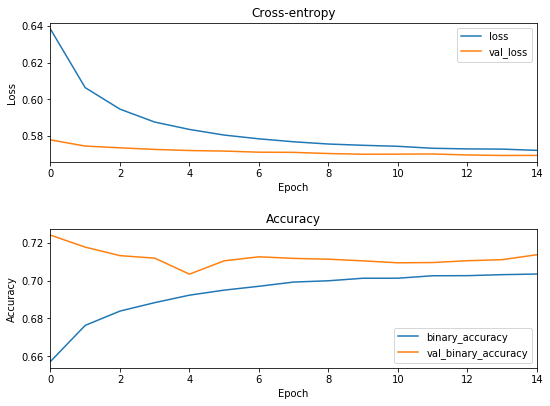

In [9]:
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0], title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=axes[1], title="Accuracy")

# Set x-axis label
axes[-1].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel('Epoch')
axes[-1].set_ylabel("Accuracy")

# Set layout and padding
fig.tight_layout(pad=2.0)
plt.show()


In [9]:
#model.save('MLP_event_run5.h5')


from tensorflow.keras.models import load_model
model = load_model('MLP_event_run5.h5')


In [11]:
history_df = pd.DataFrame(history.history)
history_df


# # Save the DataFrame to an HDF5 file
with h5py.File('MLP_run5_training_data.h5', 'w') as hf:
    hf.create_dataset('df', data=history_df)

# with h5py.File('MLP_run2_training_data.h5', 'r') as hf:
#     history_df = pd.DataFrame(hf['df'][:])

# columns = ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
# history_df =history_df.rename(columns=dict(zip(history_df, columns)))
# history_df

In [12]:
history_df.columns

Index(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'], dtype='object')

True
704876/1 - 34s - loss: 0.5524 - binary_accuracy: 0.7140
Validation loss: 0.5613213559714347
Validation accuracy: 0.71395963
704876/1 - 21s


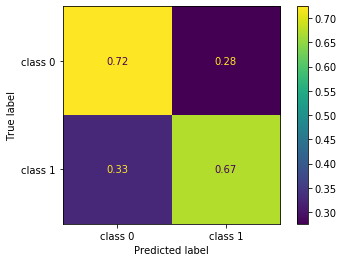

Total signal processes; 1.0
Total background processes; 1.0
250803
There is 142222 signal in the set
The model predicted 108581 more ones than in reality
454073
There is 562654 background in the set
The model predicted -108581 more ones than in reality


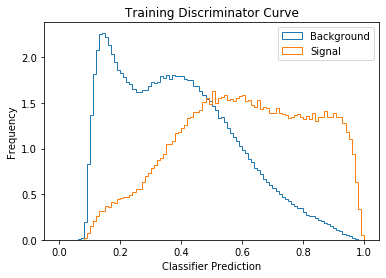

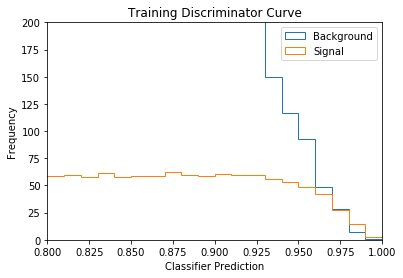

In [10]:
# evaluate the model on the training data, confusion matrix and discriminator curve

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_train, y_train, verbose = 2)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = 2)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5619128649641472
Validation accuracy: 0.7135853


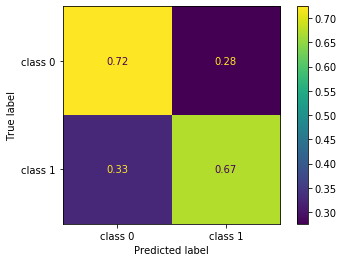

Total signal processes; 1.0
Total background processes; 1.0


In [11]:
# evaluate the model on the validation data

val_loss, val_acc = model.evaluate(X_valid, y_valid)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [12]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.713585291113381
True


In [13]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])


In [14]:
print(min(y_pred))
max(y_pred)

[0.03290063]


array([0.9989006], dtype=float32)

In [15]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.713585291113381
True


In [16]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


62720
There is 35636 signal in the set
The model predicted 27084 more ones than in reality
113500
There is 140584 background in the set
The model predicted -27084 more ones than in reality


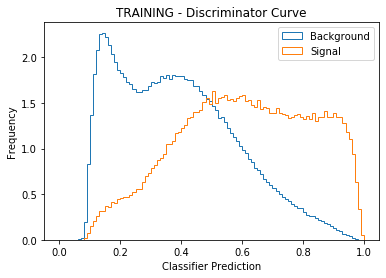

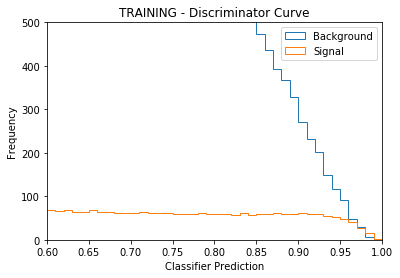

In [17]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.6,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


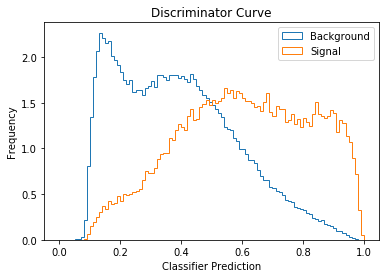

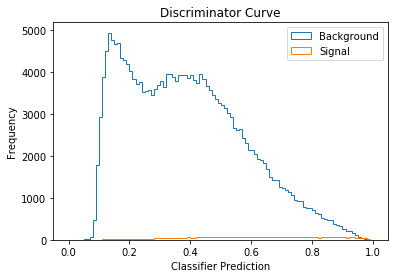

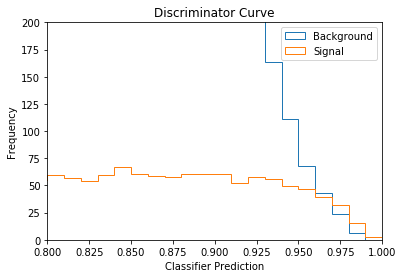

In [18]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

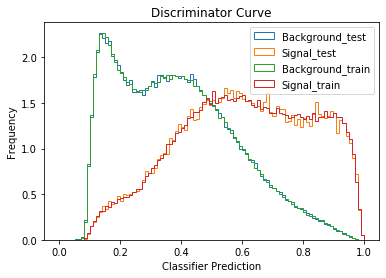

In [19]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_test')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events =  217180.32811522484
num_signal_events =  4406.9443359375


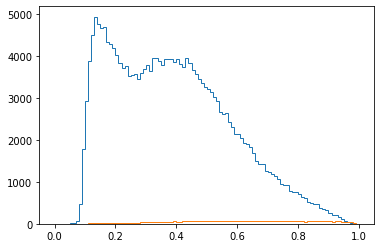

In [19]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins, weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events = ', num_bg_events)
print('num_signal_events = ', num_signal_events)

In [20]:
df['True_Val'] = df['True_Val'].astype(float)
df['Predicted'] = df['Predicted'].astype(float)
df['Round Prediction'] = df['Round Prediction'].astype(float)


# Save the DataFrame to an HDF5 file
with h5py.File('run5_ROC_data.h5', 'w') as hf:
    hf.create_dataset('df', data=df)
    
# with h5py.File('run2_ROC_data.h5', 'r') as hf:
#     df = pd.DataFrame(hf['df'][:])



In [25]:
# # Plot precision recall curve
# from sklearn.metrics import average_precision_score

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the precision-recall curve
# precision, recall, _ = precision_recall_curve(y_true, y_score)

# # plot the precision-recall curve
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall Curve')
# plt.show()

# AUC = average_precision_score(y_true, y_score)   #0.793, pretty similar to roc AUC
# print(AUC)

# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

In [26]:
s = 902
b = 4780
part1 = np.sqrt(2*((s+b)*np.log(1+(s/b))-s))
part1

12.66539152402992

217180.32811522484
4406.9443359375


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


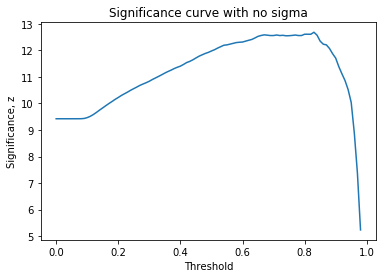

0.8300000000000001
83
12.687396506542427

If cut at a threshold of 0.83 have
836.461181640625 singal events
4076.46875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


In [32]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_0 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])
    z_i = np.sqrt(2*((s+b)*np.log(1+(s/b))-s))  
    z_0[i] = z_i

x = np.linspace(0,1,len(z_0))
plt.plot(bins_bg,z_0[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_0 = z_0 < 1e10     #just so doesnt include infs
index_of_max_0 = np.argmax(z_0[mask_0])
max_value_0 = np.amax(z_0[mask_0])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_0 = bins_bg[index_of_max_0]
print(max_bin_0)
print(index_of_max_0)
print(max_value_0)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_0 = np.sum(n_bg[index_of_max_0:])
num_signal_threshold_0 = np.sum(n_signal[index_of_max_0:])

print()
print('If cut at a threshold of', index_of_max_0/100, 'have')
print(num_signal_threshold_0, 'singal events')
print(num_bg_threshold_0, 'background events')

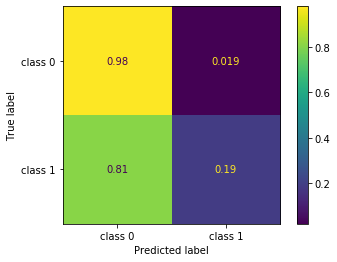

Total signal processes; 1.0
Total background processes; 1.0


In [33]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_0 = max_bin_0
y_pred_threshold_0 = np.where(y_pred >= significance_threshold_0, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_0, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217180.32811522484
4406.9443359375


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


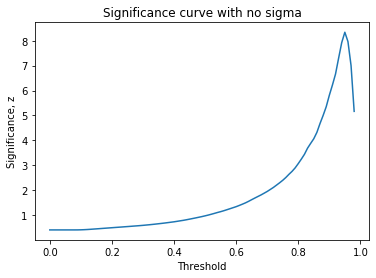

0.9500000000000001
95
8.339104714011173

If cut at a threshold of 0.95 have
135.064453125 singal events
141.140625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [34]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_5 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])

    sigma = 0.05*b  
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_5[i] = (2*(part1-part2))**(1/2)

x = np.linspace(0,1,len(z_5))
plt.plot(bins_bg,z_5[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_5 = z_5 < 1e10     #just so doesnt include infs
index_of_max_5 = np.argmax(z_5[mask_5])
max_value_5 = np.amax(z_5[mask_5])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_5 = bins_bg[index_of_max_5]
print(max_bin_5)
print(index_of_max_5)
print(max_value_5)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_5 = np.sum(n_bg[index_of_max_5:])
num_signal_threshold_5 = np.sum(n_signal[index_of_max_5:])

print()
print('If cut at a threshold of', index_of_max_5/100, 'have')
print(num_signal_threshold_5, 'singal events')
print(num_bg_threshold_5, 'background events')

In [2]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_5 = max_bin_5
y_pred_threshold_5 = np.where(y_pred >= significance_threshold_5, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

NameError: name 'max_bin_5' is not defined

217180.32811522484
4406.9443359375


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


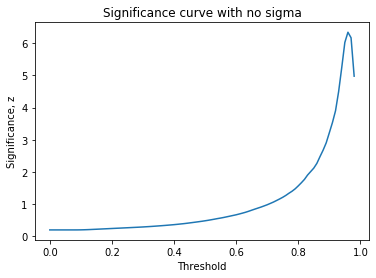

0.96
96
6.3365651468118855

If cut at a threshold of 0.96 have
88.130859375 singal events
72.953125 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [36]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_10 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])

    sigma = 0.1*b  
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_10[i] = (2*(part1-part2))**(1/2)

x = np.linspace(0,1,len(z_10))
plt.plot(bins_bg,z_10[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_10 = z_10 < 1e10     #just so doesnt include infs
index_of_max_10 = np.argmax(z_10[mask_10])
max_value_10 = np.amax(z_10[mask_10])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_10 = bins_bg[index_of_max_10]
print(max_bin_10)
print(index_of_max_10)
print(max_value_10)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_10 = np.sum(n_bg[index_of_max_10:])
num_signal_threshold_10 = np.sum(n_signal[index_of_max_10:])

print()
print('If cut at a threshold of', index_of_max_10/100, 'have')
print(num_signal_threshold_10, 'singal events')
print(num_bg_threshold_10, 'background events')

In [1]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_10 = max_bin_10
y_pred_threshold_10 = np.where(y_pred >= significance_threshold_10, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

NameError: name 'max_bin_10' is not defined

In [41]:
raw_sig_curve_data = {'syst_uncertainty (0%)': z_0, 
                      'syst_uncertainty (5%)': z_5, 
                      'syst_uncertainty (10%)': z_10, 
                     }

In [43]:
raw_sig_curve_data = {'syst_uncertainty (0%)': z_0, 
                      'syst_uncertainty (5%)': z_5, 
                      'syst_uncertainty (10%)': z_10, 
                     }
raw_sig_df = pd.DataFrame(raw_sig_curve_data)


# Save the DataFrame to an HDF5 file
with h5py.File('raw_sig_data_run5.h5', 'w') as hf:
    hf.create_dataset('df', data=raw_sig_df)
    

In [33]:
significances = np.array((max_value_0, max_value_5, max_value_10))
syst_uncertainty = np.array((0, 0.05, 0.1))
discriminators = np.array((index_of_max_0/100, index_of_max_5/100, index_of_max_10/100))
num_bg_threshold = np.array((num_bg_threshold_0, num_bg_threshold_5, num_bg_threshold_10))
num_signal_threshold = np.array((num_signal_threshold_0,num_signal_threshold_5,num_signal_threshold_10))

In [34]:
sig_curve_data = {'syst_uncertainty (%)': syst_uncertainty, 'Significances': significances, 'Threshold': discriminators, 'no_bg': num_bg_threshold, 'no_signal':num_signal_threshold}
sig_df = pd.DataFrame(sig_curve_data)


# Save the DataFrame to an HDF5 file
with h5py.File('sig_data_run5.h5', 'w') as hf:
    hf.create_dataset('df', data=sig_df)
    
# with h5py.File('run2_ROC_data.h5', 'r') as hf:
#     df = pd.DataFrame(hf['df'][:])

# can make confusion matricies with things I have saved


In [35]:

sig_df

,syst_uncertainty (%),Significances,Threshold,no_bg,no_signal
0,0.00,12.687397,0.83,4076.468750,836.461182
1,0.05,8.339105,0.95,141.140625,135.064453
2,0.10,6.336565,0.96,72.953125,88.130859


In [20]:
a=2

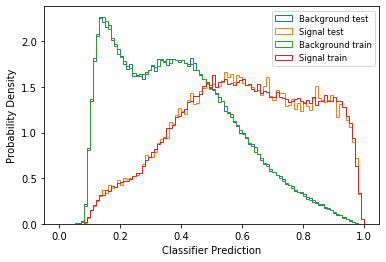

In [21]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal test')

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal train')
#plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Probability Density')
plt.legend(fontsize='small')
plt.savefig('FNN_Disc_Curve.png', dpi=300, bbox_inches='tight')


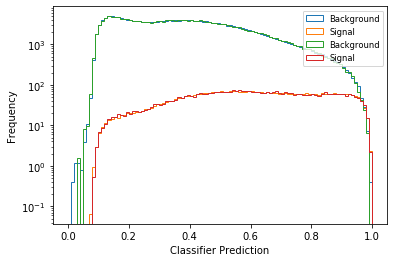

In [29]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5*1/0.8,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5*1/0.8,
         histtype = 'step', label = 'Signal')

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
#plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend(fontsize='small')
plt.show()

## Make CM's for plot

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,8))


# plot the first confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal'])
disp.plot(ax=axs[0])
axs[0].set_title('Threshold 0.5')



# plot the second confusion matrix
cm_5 = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=['Background', 'Signal'])
disp.plot(ax=axs[1])
axs[1].set_title(f'Threshold {index_of_max_5/100}')

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.35)

plt.savefig('CM_FNN.png', dpi=300, bbox_inches='tight')

